In [3]:
import pandas as pd
from src.database.database import DB
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from src.classes.process.pnl import Pnl
from matplotlib import font_manager
import matplotlib.ticker as mtick
from collections import Counter
from tqdm import tqdm
import time
import emoji
import os

LINK DO POST

In [4]:
# link do post

LINK = 'https://www.instagram.com/p/DS0xxvuERoQ/'

In [5]:
#bando de dados
load_dotenv()
con = DB.conexao()

DIM_P = os.getenv('DIM_P')
DIM_C = os.getenv('DIM_C')
T_FATO = os.getenv('T_FATO')
DIM_DATA = os.getenv('DIM_DATA')
DIM_S = os.getenv('DIM_S')



In [6]:

query = f'''
select 
	c.id_data as data,
    p.post,
    s.sentimento
from  {T_FATO} ft
inner join {DIM_DATA} c on ft.dim_calendario_id_data = c.id_data
inner join {DIM_P} p on p.id_post = ft.dim_post_id_post
inner join {DIM_S} s on s.id_sentimentos = ft.dim_sentimento_id_sentimentos
where p.post = '{LINK}'
and ( upper(s.sentimento) like '%POSITIVO%'
    or upper(s.sentimento) like '%NEGATIVO%'
    or upper(s.sentimento) like '%NEUTRO%'  )

 

;
'''
df = pd.read_sql(query,con)
df['qtde'] = 1

display(df)



C:\Users\bk\AppData\Local\Temp\ipykernel_46980\1764976575.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,con)
C:\Users\bk\AppData\Local\Temp\ipykernel_46980\1764976575.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updat

,data,post,sentimento,qtde
0,2025-12-28,https://www.instagram.com/p/DS0xxvuERoQ/,Negativo,1
1,2025-12-28,https://www.instagram.com/p/DS0xxvuERoQ/,Negativo,1
2,2025-12-28,https://www.instagram.com/p/DS0xxvuERoQ/,Negativo,1
3,2025-12-28,https://www.instagram.com/p/DS0xxvuERoQ/,Negativo,1
4,2025-12-28,https://www.instagram.com/p/DS0xxvuERoQ/,Negativo,1
...,...,...,...,...
7260,2025-12-28,https://www.instagram.com/p/DS0xxvuERoQ/,Neutro,1
7261,2025-12-28,https://www.instagram.com/p/DS0xxvuERoQ/,Neutro,1
7262,2025-12-28,https://www.instagram.com/p/DS0xxvuERoQ/,Neutro,1
7263,2025-12-28,https://www.instagram.com/p/DS0xxvuERoQ/,Neutro,1


Gráfico de barras

C:\Users\bk\AppData\Local\Temp\ipykernel_46980\1128953831.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_grafico['percentual'] = (df_grafico['qtde'] / total) * 100


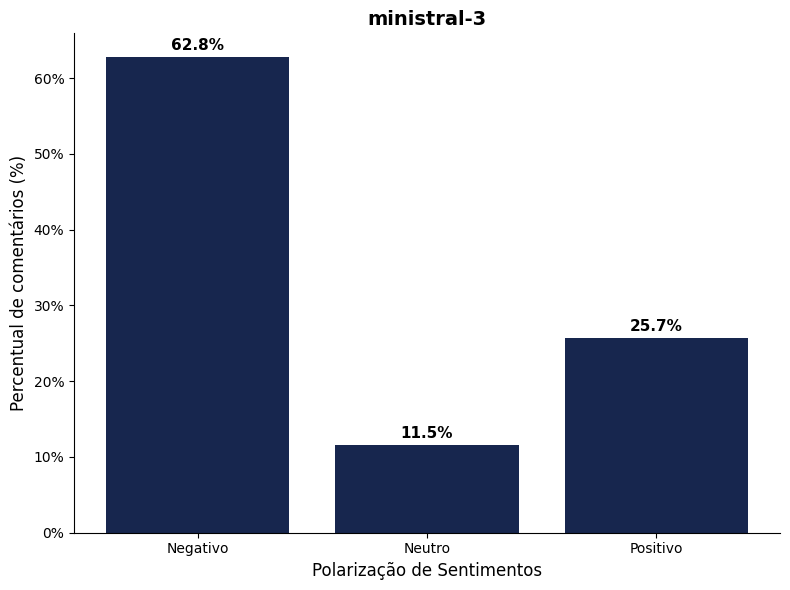

In [7]:

# 1. Agrupamento original (mantive o seu, mas recomendo garantir que 
#    estamos somando o total por sentimento para o gráfico)
df_tratato = df.groupby(by=['data', 'sentimento', 'post'])['qtde'].sum().reset_index()

# Para o gráfico, é mais seguro agrupar apenas por sentimento, 
# caso haja várias datas/posts, para não sobrepor barras no eixo X
df_grafico = df_tratato.groupby('sentimento')['qtde'].sum().reset_index()

# 2. Calcular o percentual
total = df_grafico['qtde'].sum()
df_grafico['percentual'] = (df_grafico['qtde'] / total) * 100

# 3. Plotagem
fig, ax = plt.subplots(figsize=(8, 6))

# Usar a coluna de percentual e a cor solicitada (#17264e)
barras = ax.bar(df_grafico['sentimento'], df_grafico['percentual'], color='#17264e')

# 4. Adicionar os rótulos formatados com % (Ex: 45.2%)
ax.bar_label(barras, fmt='%.1f%%', padding=3, fontsize=11, fontweight='bold')

# Configurações de texto e eixos
ax.set_xlabel('Polarização de Sentimentos', fontsize=12)
ax.set_ylabel('Percentual de comentários (%)', fontsize=12)
ax.set_title('ministral-3', fontsize=14, fontweight='bold')

# (Opcional) Formatar o eixo Y para mostrar o símbolo de % automaticamente
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# (Opcional) Limpar as bordas do gráfico para ficar mais elegante
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [8]:
query_comment =f'''
select 
	c.comentario
from  {T_FATO} ft
inner join {DIM_P} p on p.id_post = ft.dim_post_id_post
inner join {DIM_C} c on ft.dim_comentario_id_comentario = c.id_comentario
where p.post = '{LINK}';
'''
df2 = pd.read_sql(query_comment, con)
df2.dropna()
df2.drop_duplicates()
display(df2)

C:\Users\bk\AppData\Local\Temp\ipykernel_46980\3761884586.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query_comment, con)


,comentario
0,Estamos todos condenados.
1,Eu acho isso aí assustador real!!!
2,Cara isso é insano
3,Acreditem nos livros.
4,Temos que exigir a REGULAMENTAÇÃO DAS IAS e U...
...,...
7445,Lula nem usou isso e foi presidente !
7446,Mas também se não reconhecer que é IA né 😂
7447,"Faz um vídeo do falso advogado, esse tipo de ..."
7448,😂


In [9]:
amostra = df2.sample(1)
display(amostra)

,comentario
563,Muito bom! É preciso informar mais 👍


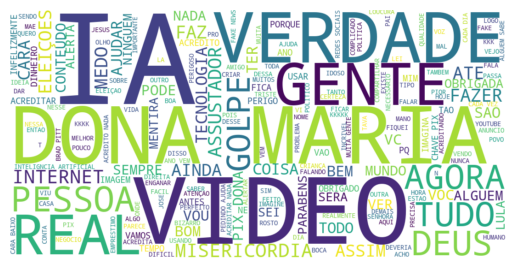

In [68]:

comentarios_ = Pnl.apply_stop_word(df2)

texto = ' '.join(comentarios_)

nuvem_de_palavras = WordCloud(background_color='white',width=1080, height=540).generate(texto)


fig, ax = plt.subplots()
ax.imshow(nuvem_de_palavras,interpolation='bilinear')

ax.set_axis_off()

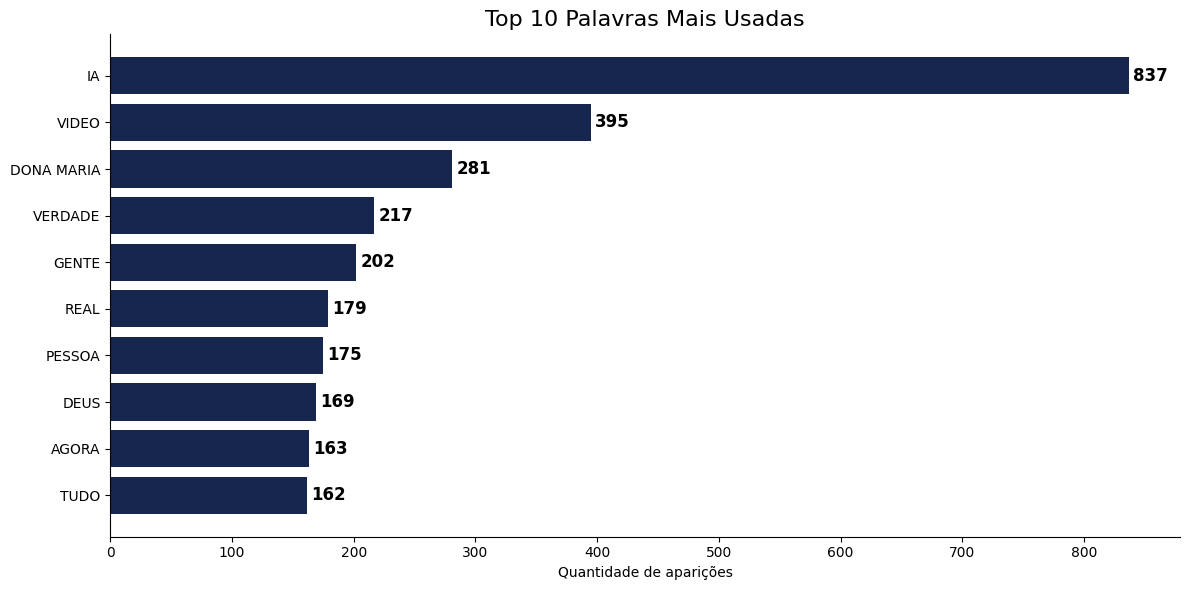

In [13]:
wc = WordCloud(background_color='white', width=1080, height=540)
dic_palavras = wc.process_text(texto)

# 3. Ordenar e pegar o Top 10
top_10 = sorted(dic_palavras.items(), key=lambda x: x[1], reverse=True)[:10]
palavras = [item[0] for item in top_10]
quantidades = [item[1] for item in top_10]

# 4. Plotagem
fig, ax = plt.subplots(figsize=(12, 6))

# Salve o gráfico numa variável 'barras' para usarmos depois
barras = ax.barh(palavras, quantidades, color="#17264e")

# --- O QUE VOCÊ PEDIU: ADICIONAR OS VALORES ---
# O padding=3 dá um espacinho entre a barra e o número
ax.bar_label(barras, padding=3, fmt='%d', fontsize=12, fontweight='bold')

# Ajustes visuais
ax.invert_yaxis()  # Maior no topo
ax.set_title('Top 10 Palavras Mais Usadas', fontsize=16)
ax.set_xlabel('Quantidade de aparições')

# Remove as bordas desnecessárias (superior e direita) para ficar mais limpo
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [14]:
#print(dic_palavras)
print(dic_palavras)

{'ACHO': 51, 'ASSUSTADOR': 142, 'REAL': 179, 'CARA': 115, 'INSANO': 9, 'ACREDITEM': 9, 'EXIGIR': 2, 'REGULAMENTAÇAO': 20, 'URGENTR': 1, 'FACEBOOK': 6, 'SAO': 91, 'CRIANDO': 9, 'IMAGENS': 20, 'IA': 837, 'COMOVENTES': 1, 'ENGAJAR': 1, 'MONETIZAR': 1, 'PERIGO': 64, 'TAMANHO': 5, 'ESTAO': 38, 'INTEGRADAS': 1, 'MUNDO': 77, 'DIGITAL': 11, 'CONFUNDEM': 1, 'IMAGINEM': 3, 'PUBLICO': 7, 'MENOS': 19, 'ACOSTUMADO': 2, 'TECNOLOGIA': 107, 'URGENTE': 14, 'OBRIGATORIEDADE': 1, 'SINALIZAÇAO': 1, 'EVIDENTE': 1, 'TODO': 91, 'CONTEUDO': 85, 'GERADO': 8, 'FIQUEI': 32, 'MARIA': 21, 'BOM': 82, 'GALERA': 22, 'ESTRANHAMENTE': 1, 'INCRIVEL': 31, 'OLHAR': 7, 'DENUNCIA': 9, 'PUPILAS': 1, 'DILATAM': 1, 'GLOBO': 5, 'FICA': 56, 'IMOVEL': 1, 'PISCAR': 1, 'ESQUISITO': 2, 'PROIBIDA': 2, 'ARMA': 13, 'PRECEDENTES': 2, 'DEUS': 169, 'MEDO': 130, 'BLACK': 1, 'PIOR': 52, 'SERIE': 7, 'VEM': 29, 'ATREVO': 1, 'DIZER': 24, 'JAJA': 3, 'MOVIMENTAÇAO': 2, 'PROL': 1, 'VIDA': 51, 'OFFLINE': 1, 'JUSTAMENTE': 2, 'FALTA': 11, 'VERACIDAD

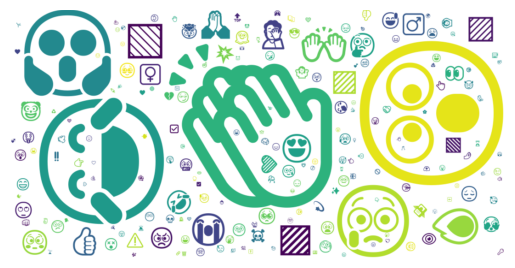

In [15]:

comentarios_emojis = Pnl.only_emojis(df2)

texto_emoji = ' '.join(comentarios_emojis)


font_path = r"C:\Windows\Fonts\seguiemj.ttf"


nuvem_de_palavras = WordCloud(
    font_path=font_path,    
    width=1080, height=540,
    background_color='white',
    collocations=False,      
    regexp=r"\S+"             
).generate(texto_emoji)



fig, ax = plt.subplots()
ax.imshow(nuvem_de_palavras,interpolation='bilinear')

ax.set_axis_off()

C:\Users\bk\AppData\Local\Temp\ipykernel_46980\1429211076.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(emojis, fontproperties=propriedade_fonte, fontsize=25)


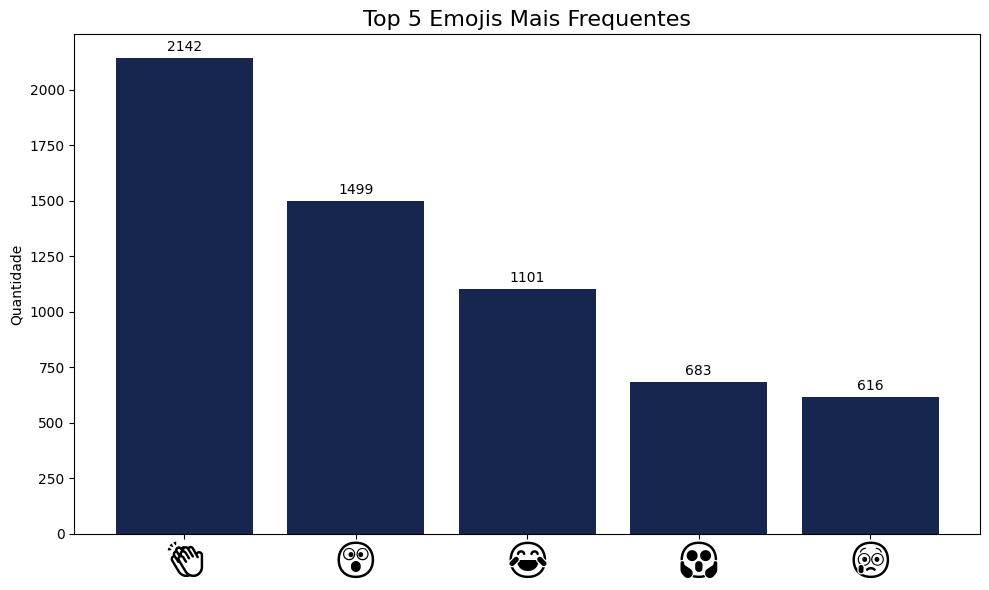

In [16]:




lista_emojis = texto_emoji.split()
contagem = Counter(lista_emojis)

# Pegar os 5 mais comuns
# Retorna uma lista de tuplas: [('😂', 50), ('🔥', 30), ...]
top_5 = contagem.most_common(5)

emojis = [item[0] for item in top_5]
freqs = [item[1] for item in top_5]

# 2. Configurar a fonte para o Eixo X
# Isso é crucial: criamos uma "propriedade de fonte" apontando para o arquivo de emoji
propriedade_fonte = font_manager.FontProperties(fname=font_path)

# 3. Plotar o Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
barras = ax.bar(emojis, freqs, color="#17264e") # Amarelo "emoji"

# Título e Labels
ax.set_title('Top 5 Emojis Mais Frequentes', fontsize=16)
ax.set_ylabel('Quantidade')

# --- O TRUQUE PARA MOSTRAR OS EMOJIS ---
# Aplicamos a fonte personalizada apenas nos labels do eixo X
ax.set_xticklabels(emojis, fontproperties=propriedade_fonte, fontsize=25)

# (Opcional) Adicionar o número em cima da barra
for bar in barras:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()